In [14]:
%matplotlib inline
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os

In [18]:
g17_b02 = xr.open_dataset('/home/jovyan/goes17/2018/12/12/ABI-L1b-RadC/18/C02/OR_ABI-L1b-RadC-M3C02_G17_s20183461827189_e20183461829502_c20183461829528.nc')

In [60]:
g17_b02;

In [17]:
def ABIangle2LatLon(x, y, H, req, rpol, lon_0):
    '''Find the latitude and longitude (degrees) of point P given x and y, ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat) #*
    lon = lon_0 - np.arctan( Sy / ( H - Sx ))
    
    return (lat,lon)

#* There was a typo here in the PUG document, latitude needs to be converted from radians to degrees, 
#  whereas latitude was already in degrees.

In [20]:
# make a 2d array of both x and y in radians
x, y = np.meshgrid(g17_b02.x.values, g17_b02.y.values)

# Values needed for geometry calculations
req = g17_b02.goes_imager_projection.semi_major_axis # semi major axis
rpol = g17_b02.goes_imager_projection.semi_minor_axis
H = g17_b02.goes_imager_projection.perspective_point_height + g17_b02.goes_imager_projection.semi_major_axis
lon_0 = g17_b02.goes_imager_projection.longitude_of_projection_origin

# Get lat and lon values
lat, lon = ABIangle2LatLon(x,y,H,req,rpol,lon_0)

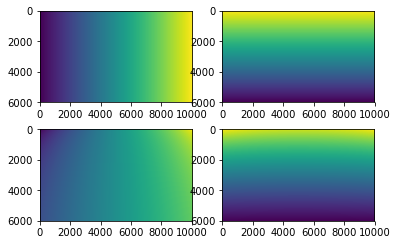

In [53]:
# Visualize the arrays of x, y (scan angle radians), and longitude, latitude (degrees)
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x)
ax[0,1].imshow(y)
ax[1,0].imshow(lon)
ax[1,1].imshow(lat)

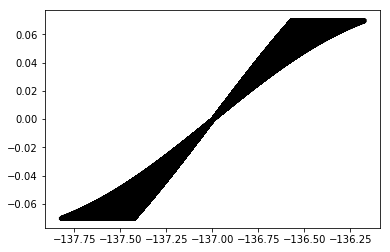

In [58]:
# Visualize longitude (degrees) vs x (scan angle radians)
plt.plot(lon,x,'.k',alpha=0.01);

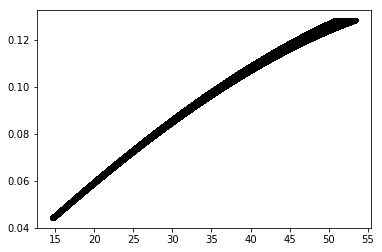

In [59]:
# Visualize latitude (degrees) vs y (scan angle radians)
plt.plot(lat,y,'.k',alpha=0.01);

In [61]:
# Fit RPCs to these two surfaces:
